In [1]:
from FKBP_openmm.MDSimulation import MDSimulation
import time
from IPython.display import clear_output


In [2]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics


In [3]:
%%bash
for i in {2..4}; do
  cp -r simulation/initial_trial/initial_trial1 simulation/initial_trial/initial_trial$i
done


#### SIMULATION PARAMETERS + FILES

In [4]:
simutlation_steps = 1000000 # 1000000*0.002 ps >> 2000ps = 2ns
plumed_file_name = 'plumed_initial.dat' 
threshold_val = 1.8 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation = 4
dir_path = '/initial_trial'

#### RUN FIRST SET OF SIMULATION (MetaD with Trial Variables)

In [5]:
# Define your simulation steps as a separate function
def run_simulation_round(i, simutlation_steps, plumed_file_name, threshold_val,dir_path):
    clear_output(wait=True)    
    print('***** Currently Running %i round of simulation******' % i)
    sim_directory = dir_path+'%i' % i
    md_sim = MDSimulation(work_dir= '/simulation'+dir_path + sim_directory)

    with md_sim.working_directory():
        md_sim.remove_previous_old_files()  # if exist, delete old files
    
        # Simulation Set-Up
        simulation = md_sim.simulation_preperation(equilibration=False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        
        print("Simulating...")  
        # Placeholder for simulation execution. Replace with your actual simulation call
        md_sim.run_MD(simulation, positions, nsteps=simutlation_steps, report_steps=False, committor=True,
                      use_plumed=True, plumed_file=plumed_file_name, stride=500, threshold=threshold_val)
        
        md_sim.remove_last_line()
md_sim = MDSimulation()        

In [6]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1    10.801313    10.801313    10.801313    10.801313
PLUMED: 1 Prepare dependencies                         52001     0.059899     0.000001     0.000000     0.000024
PLUMED: 2 Sharing data                                 52001     5.366232     0.000103     0.000091     0.003880
PLUMED: 3 Waiting for data                             52001     0.010398     0.000000     0.000000     0.000009
PLUMED: 4 Calculating (forward loop)                   52001     0.859612     0.000017     0.000005     0.000215
PLUMED: 5 Applying (backward loop)                     52001     3.904603     0.000075     0.000062     0.000646
PLUMED: 6 Update                                       52000     0.215467     0.000004

## Select appropriate OPs for SPIB tranining 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
from sklearn.cluster import KMeans
from itertools import groupby
import sys
import os

In [8]:
!pwd
%cd SPIB_kinetics/

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics
[Errno 2] No such file or directory: 'SPIB_kinetics/'
/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics


In [9]:
orginal_path = os.path.abspath('.') 

data_list=[]
data_list_str=[]

for i in range(1,5):
    print(i)
    sim_path = '/simulation/initial_trial/initial_trial%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()

    locals()['metaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))

os.chdir(orginal_path)

1


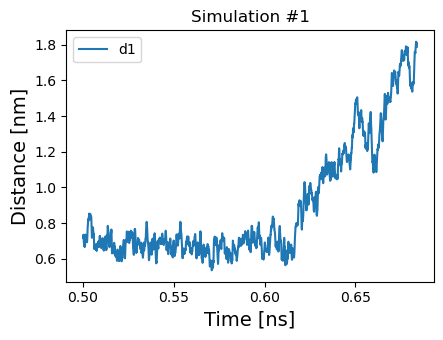

In [10]:
# visualize the data and also initiate K-mean Clustering +Labeling

work_dir = '/SPIB_training/SPIB01'
os.chdir(orginal_path+work_dir)

plt.figure(figsize=(16,3.5))

for i, simulation_data in enumerate(data_list): 
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-3]] # take time and the 426th colums of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]] 
    bias_distance = simulation_data[:,[0,-4]] 
    traj_raw = simulation_data[:,[-3,-4]]

    time = bias_distance[:,0]/1000
    
    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('Simulation #%i'%(i+1))

    ######
    # One-hot encoded initial state assignment: Using K-mean clustering
    ######
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)    
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)  

    distance_simulation_data = simulation_data[:,1:29] 
    
    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()
# Combine all SPIB output data files for all 4 trajectories
concatenate_data = np.concatenate(data_list, axis=0)[:,1:29]

concatenate_data_mean = np.mean(concatenate_data, axis=0)
concatenate_data_std = np.std(concatenate_data, axis=0)

np.save('data/FKBP_distance_data_mean.npy', concatenate_data_mean)    
np.save('data/FKBP_distance_data_std.npy', concatenate_data_std)  
    

In [11]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB01


## RUN SPIB stage 1

In [12]:
# # run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories 
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


tensor([0.0000, 0.0000, 0.0000, 0.5843, 0.0000, 0.0000, 0.0000, 0.0733, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3188, 0.0000, 0.0236, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.635541
Update lr to 0.000010
Epoch: 1

Iteration 500:	Time 2.050079 s
Loss (train) 2.962619	KL loss (train): 2.531416
Reconstruction loss (train) 2.962366
Loss (test) 2.978899	KL loss (test): 2.378853
Reconstruction loss (test) 2.978661
tensor([0.0000, 0.0000, 0.0738, 0.5864, 0.0000, 0.0000, 0.0000, 0.0044, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2475, 0.0000, 0.0879, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.139365
Update lr to 0.000010
Epoch: 2

tensor([0.0000e+00, 0.0000e+00, 3.0914e-01, 5.2014e-01, 0.0000e+00, 0.0000e+00,
        4.8249e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.7498e-04, 0.0000e+00,
        1.0527e-01, 0.0000e+00, 2.7749e-03, 5.6474e-02, 0.0000e+00, 0.0000e+00,
        3.9999e-04, 0.0000e+

## Generate Plume file from learn RC for MetaD

In [13]:
!python plumed_generator.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.2827732  0.29382002]


In [40]:
# !pwd
# %cd /ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB01

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB01
/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB01


In [14]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB01


In [15]:
!mv data/plumed_metaD_ANN.dat ../../simulation/01_metaD/01_metaD1
%cd ../../

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics


## Prepare for first SPIB stage of metadynmaics 

In [16]:
%%bash
for i in {2..4}; do 
    cp -r simulation/01_metaD/01_metaD1 simulation/01_metaD/01_metaD$i
done

In [18]:
## SIMULATION PARAMETERS + FILES
simutlation_steps = 500000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat' 
threshold_val = 1.8 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation= 4
dir_path = '/01_metaD'

In [19]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1   158.701505   158.701505   158.701505   158.701505
PLUMED: 1 Prepare dependencies                        127501     0.358419     0.000003     0.000002     0.000021
PLUMED: 2 Sharing data                                127501    13.020964     0.000102     0.000089     0.003272
PLUMED: 3 Waiting for data                            127501     0.033586     0.000000     0.000000     0.000016
PLUMED: 4 Calculating (forward loop)                  127501     9.011189     0.000071     0.000054     0.002615
PLUMED: 5 Applying (backward loop)                    127501    14.052150     0.000110     0.000096     0.000739
PLUMED: 6 Update                                      127500   121.304977     0.000951

In [20]:
!pwd
# %cd ../

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics


In [21]:
orginal_path = os.path.abspath('.') 

data_list=[]
data_list_str=[]

print('...Loading...')
for i in range(1,5):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/01_metaD/01_metaD%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()
    
    locals()['metaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))

os.chdir(orginal_path)

...Loading...
Simulation 1 Trajectory


In [22]:
!pwd
%cd SPIB_training/SPIB02

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics
/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB02


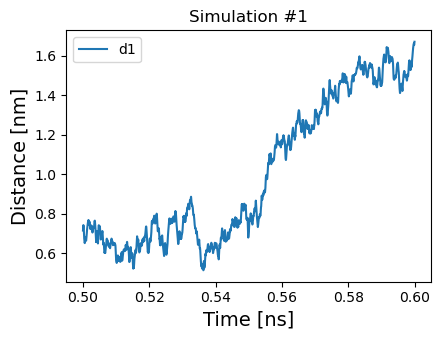

In [23]:

# visualize the data 
plt.figure(figsize=(16,3.5))
for i, simulation_data in enumerate(data_list): 
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-5]] # take time and the 426th columns of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]] 
    bias_distance = simulation_data[:,[0,-5]] 
    traj_raw = simulation_data[:,[-4,-3]]
    
    time = bias_distance[:,0]/1000
    
    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('Simulation #%i'%(i+1))

#     #####
#     One-hot encoded initial state assignment: Using K-mean clustering
#     #####
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)    
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)  

    distance_simulation_data = simulation_data[:,1:29] 
    
    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()

## RUN SPIB stage 2

In [24]:
# run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories 
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


tensor([0.0000, 0.0000, 0.0000, 0.5680, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3902, 0.0000, 0.0418, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.625655
Update lr to 0.000010
Epoch: 1

Iteration 500:	Time 2.101114 s
Loss (train) 2.982236	KL loss (train): 2.827426
Reconstruction loss (train) 2.981953
Loss (test) 2.987553	KL loss (test): 2.865100
Reconstruction loss (test) 2.987267
tensor([0.0000, 0.0000, 0.0000, 0.5658, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.2388, 0.0000, 0.1954, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.215666
Update lr to 0.000010
Epoch: 2

Iteration 1000:	Time 3.680922 s
Loss (train) 2.972252	KL loss (train): 3.770238
Reconstruction loss (train) 2.971875
Loss (test) 2.945955	KL loss (test): 3.182054
Reconstruction loss (test) 2.945636
tensor([0.0000, 0.0000, 0.0000, 0.5612, 0.0000, 0.0000, 0.0000, 0.000

## Generate Plume file from learn RC for MetaD


In [25]:
!python plumed_generator_v2.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.32467312 0.34744462]


In [26]:
!mv data/plumed_metaD_ANN.dat ../../simulation/02_inMetaD/02_inMetaD1

In [27]:
!pwd
%cd ../../

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics/SPIB_training/SPIB02
/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics


## Prepare for Second SPIB stage/ Final infrequent metadynamics 

In [28]:
%%bash
for i in {2..4}; do 
    cp -r simulation/02_inMetaD/02_inMetaD1 simulation/02_inMetaD/02_inMetaD$i
done

In [29]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/colab/SPIB_kinetics


In [30]:
## SIMULATION PARAMETERS + FILES
simutlation_steps = 2000000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat' 
threshold_val = 2.0 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation= 4
dir_path = '/02_inMetaD'

In [ ]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 3 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1    58.450913    58.450913    58.450913    58.450913
PLUMED: 1 Prepare dependencies                        176001     0.523142     0.000003     0.000002     0.000032
PLUMED: 2 Sharing data                                176001    17.664243     0.000100     0.000083     0.003861
PLUMED: 3 Waiting for data                            176001     0.039483     0.000000     0.000000     0.000013
PLUMED: 4 Calculating (forward loop)                  176001    12.307938     0.000070     0.000054     0.001570
PLUMED: 5 Applying (backward loop)                    176001    19.525687     0.000111     0.000097     0.001980
PLUMED: 6 Update                                      176000     7.184144     0.000041

In [ ]:
orginal_path = os.path.abspath('.') 

data_list_2=[]
data_list_str_2=[]

print('...Loading...')
for i in range(1,2):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/02_inMetaD/02_inMetaD%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()
    # remove_line_change_rows()
    
    locals()['inMetaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list_2.append(locals()['inMetaD{0}'.format(i)])
    data_list_str_2.append('inMetaD{0}'.format(i))

os.chdir(orginal_path)

## Calculate residence time and curve fit

In [ ]:
residence_t_data = []

# Loop over the data points in 'data_list'
for i in range(len(data_list_2)):
    simulation_data = data_list_2[i]
    # Extract the time and bias columns from the simulation data
    time = simulation_data[:,0]
    bias = simulation_data[:,-2]
    # Calculate the time step (dt)
    dt = (time[-1]-time[-2])*1e-12
    k_B = 8.314462 
    T = 300 
    kbT = k_B*T/1000 
    
    # Calculate the acceleration factor
    acceleration = np.exp(bias/kbT)
    residence_t = acceleration*dt
    residence_t = np.sum(residence_t)
    # print(residence_t)
    # Add the calculated residence time to the list of residence time data
    residence_t_data.append(residence_t)


In [ ]:
residence_t_data

# CURVE FIT

###### 
Now all the simulations + SPIB is DONE! 
Moving on to our final steps of curve fit

In [ ]:
!pwd

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import expon
from scipy import stats

In [ ]:
residence_t_data_extra = np.load('simulation/residence_t_extra.npy')

In [ ]:
def include_extra_data(residence_t_data,residence_t_data_extra, num_sample=4):
    random_values = np.random.choice(residence_t_data_extra, size=num_sample, replace=False)
    return np.concatenate((np.array(residence_t_data), random_values))

In [ ]:
len(data)

In [ ]:
data = include_extra_data(residence_t_data,residence_t_data_extra,num_sample=4)

if len(data)<5: 
    raise ValueError("The total number of data set is too small. Include more samples")
    
else:   
    x_min, x_max = np.min(data),np.max(data)
    log_bin = np.logspace(np.log10(x_min),np.log10(x_max), 100)
    count, bins_count = np.histogram(data, bins=log_bin)
    bin_centers = 0.5 * (bins_count[1:] + bins_count[:-1])
    
    pdf = count/sum(count)
    cdf = np.cumsum(pdf)
    
    plt.figure(figsize=(5,4))
    plt.plot(bin_centers, cdf,'--',label='Simulation cdf',color="dimgray")
    plt.xlabel(r'Residence time (s)',fontsize=14)
    plt.ylabel('Probability density',fontsize=14)
    
    def fit_function(k, lamb):
        return expon.cdf(k,0,lamb)
    
    # curve_fit with the poisson cdf 
    parameters, cov_matrix = curve_fit(fit_function, bin_centers, cdf)
    residenceT = parameters *10**9
    print('tau =',residenceT)
    
    fit_results = fit_function(bin_centers, parameters)
    plt.plot(bin_centers,fit_results,label='Simulation curve fit',color="red")
    
    # Unbiased result
    unbiased = 12.59 *10**-9
    unbiased_y = fit_function(bin_centers, unbiased)
    plt.plot(bin_centers,unbiased_y,'--',label='Unbiased result',color="deepskyblue")
    
    # SPIB-iMetaD result
    SPIB_metaD = 36.22 *10**-9
    SPIB_metaD_y = fit_function(bin_centers, SPIB_metaD)
    plt.plot(bin_centers,SPIB_metaD_y,'--',label='SPIB-iMetaD result',color="navy")

    plt.xscale('log')
    plt.legend(fontsize = 12)
    plt.title(r'Residence T = %3.2f ns'%residenceT,fontsize = 14)
    
    stats.kstest(data,expon.cdf,(0, parameters))
